Importing libraries and datasets that I will be using (Needed to create a new virtual environment)

In [20]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import os
import json
import nltk #error in summac since SummaC uses NLTK’s sentence tokenizer, which relies on a pre-trained model called punkt
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM #, Trainer, TrainingArguments
from IPython.display import SVG, display
from tqdm.notebook import tqdm
from rouge_score import rouge_scorer
from bert_score import score
from summac.model_summac import SummaCZS, SummaCConv #this is not compatible with transformers so have to disable and re-enable when used
from bertviz import model_view

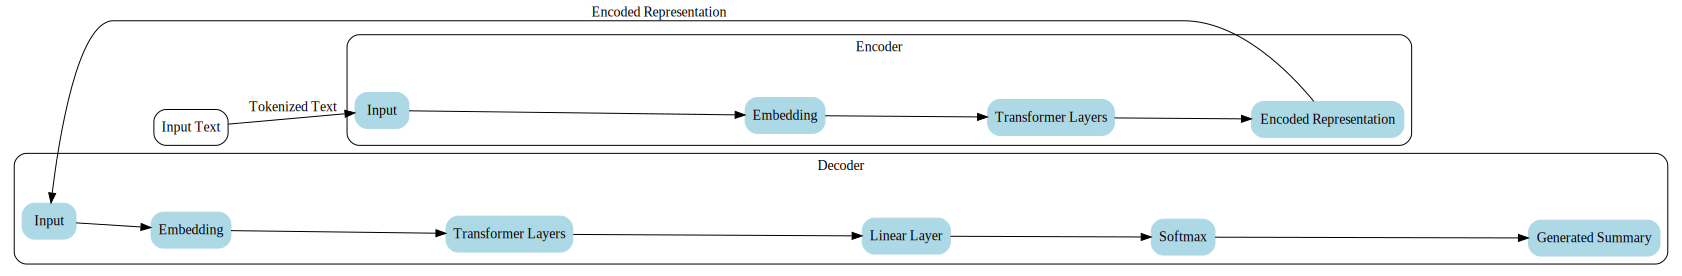

In [3]:
pegasus_svg = "pegasus.svg"
display(SVG(filename=pegasus_svg))

In [21]:
# # Create directory
# !mkdir -p ./xsum_data

# # Download files with quotes
# !curl -L 'https://www.dropbox.com/s/91carhrcirxxu2a/train.bbc.gz?dl=1' -o ./xsum_data/train.bbc.gz
# !curl -L 'https://www.dropbox.com/s/ctg3lbk1tqcxgv3/validation.bbc.gz?dl=1' -o ./xsum_data/validation.bbc.gz
# !curl -L 'https://www.dropbox.com/s/15j8s6r7yxyq4jx/test.bbc.gz?dl=1' -o ./xsum_data/test.bbc.gz
# !curl -L 'https://raw.githubusercontent.com/EdinburghNLP/XSum/master/XSum-Dataset/XSum-TRAINING-DEV-TEST-SPLIT-90-5-5.json' -o ./xsum_data/XSum-TRAINING-DEV-TEST-SPLIT-90-5-5.json

Tried to manually access xsum by downloading the files locally but it was giving me a lot of errors still concerning certificate and ssl. I decided to just load the dataset EdinburghNLP/xsum rather than trying to load xsum. I'm pretty sure it does the same thing. Instead of pointing directly to huggling face or locally, it points to the github repo.

In [2]:
cnn = load_dataset("cnn_dailymail", "3.0.0")

README.md:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/6.24k [00:00<?, ?B/s]

xsum.py:   0%|          | 0.00/5.76k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/304M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/16.7M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/17.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/204045 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11332 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11334 [00:00<?, ? examples/s]

In [53]:
print(cnn["train"][0])

{'article': 'LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won\'t cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don\'t plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don\'t think I\'ll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box office char

## Initializing the models

Testing normal pegasus to see if it works correctly.

In [19]:
pegasus_model_normal = AutoModelForSeq2SeqLM.from_pretrained("google/pegasus-large")
pegasus_tokenizer_normal = AutoTokenizer.from_pretrained("google/pegasus-large")

bart_model_normal = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-large")
bart_tokenizer_normal = AutoTokenizer.from_pretrained("facebook/bart-large")

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-large and are newly initialized: ['model.encoder.embed_positions.weight', 'model.decoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Generating inferences or model summaries

In [42]:
def summarize(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=1024)
    outputs = model.generate(**inputs, max_new_tokens=128)
    #inputs = {k: v.to(device) for k, v in inputs.items()}
    return tokenizer.decode(outputs[0], skip_special_tokens=True)
article = "In (9.4), the phrase The keys is the subject of the sentence, and in English and many languages, must agree in grammatical number with the verb are; in this case both are plural. In English we can’t use a singular verb like is with a plural subject like keys (we’ll discuss agreement more in Chapter 18). In (9.5), we know that bank refers to the side of a pond or river and not a financial institution because of the context,including words like pond. (We’ll discuss word senses more in Chapter 11.) The point of all these examples is that these contextual words that help us compute the meaning of words in context can be quite far away in the sentence or paragraph. Transformers can build contextual representations of word meaning, contextual embeddings, by integrating the meaning of these helpful contextual words. In a contextual embeddings transformer, layer by layer, we build up richer and richer contextualized representations of the meanings of input tokens. At each layer, we compute the representation of a token i by combining information about i from the previous layer with information about the neighboring tokens to produce a contextualized representation for each word at each position."
print("Pegasus:", summarize(article, pegasus_model_normal, pegasus_tokenizer_normal))

Pegasus: The point of all these examples is that these contextual words that help us compute the meaning of words in context can be quite far away in the sentence or paragraph .<n>Transformers can build contextual representations of word meaning, contextual embeddings, by integrating the meaning of these helpful contextual words .


In [20]:
# Pegasus (use a CNN/DailyMail Finetuned Variant will do one for XSum too)
#skip size checks and allow custom code
pegasus_model = AutoModelForSeq2SeqLM.from_pretrained("google/pegasus-cnn_dailymail", output_attentions = True) #ignore_mismatched_sizes = True, trust_remote_code = True, 
pegasus_tokenizer = AutoTokenizer.from_pretrained("google/pegasus-cnn_dailymail", use_fast = True)

bart_model = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-large-cnn", output_attentions = True)
bart_tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-cnn")

#This Pegasus error can be ignored if I'm only running inference (not training)

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.encoder.embed_positions.weight', 'model.decoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [48]:
article = "In (9.4), the phrase The keys is the subject of the sentence, and in English and many languages, must agree in grammatical number with the verb are; in this case both are plural. In English we can’t use a singular verb like is with a plural subject like keys (we’ll discuss agreement more in Chapter 18). In (9.5), we know that bank refers to the side of a pond or river and not a financial institution because of the context,including words like pond. (We’ll discuss word senses more in Chapter 11.) The point of all these examples is that these contextual words that help us compute the meaning of words in context can be quite far away in the sentence or paragraph. Transformers can build contextual representations of word meaning, contextual embeddings, by integrating the meaning of these helpful contextual words. In a contextual embeddings transformer, layer by layer, we build up richer and richer contextualized representations of the meanings of input tokens. At each layer, we compute the representation of a token i by combining information about i from the previous layer with information about the neighboring tokens to produce a contextualized representation for each word at each position."
print("PEGASUS:", summarize(article, pegasus_model, pegasus_tokenizer))
print("BART:", summarize(article, bart_model, bart_tokenizer))

PEGASUS: The point of all these examples is that these contextual words that help us compute the meaning of words in context can be quite far away in the sentence or paragraph .<n>Transformers can build contextual representations of word meaning, contextual embeddings, by integrating the meaning of these helpful contextual words .
BART: In (9.4), the phrase The keys is the subject of the sentence, and in English and many languages, must agree in grammatical number with the verb are; in this case both are plural. We know that bank refers to the side of a pond or river and not a financial institution because of the context. Transformers can build contextual representations of word meaning, contextual embeddings, by integrating the meaning of these helpful contextual words.


In [46]:
print(pegasus_model.model.encoder.embed_positions.weight) #checking to see if it is all 0s to see if it is working correctly

Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  1.0000,  1.0000,  1.0000],
        [ 0.8415,  0.8317,  0.8219,  ...,  1.0000,  1.0000,  1.0000],
        [ 0.9093,  0.9236,  0.9364,  ...,  1.0000,  1.0000,  1.0000],
        ...,
        [ 0.0176, -0.5887, -0.9995,  ...,  0.9942,  0.9944,  0.9946],
        [-0.8318, -0.9992, -0.5446,  ...,  0.9942,  0.9944,  0.9946],
        [-0.9165, -0.5208,  0.3790,  ...,  0.9942,  0.9944,  0.9946]])


In [23]:
from tqdm.notebook import tqdm

# function to create a comparison dataset between ground truth and inferences that we create
def create_comparison_dataset(dataset, model_1, tokenizer_1, model_2, tokenizer_2, num_samples=5):
    comparisons = []
    
    #attempt to make it faster
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
    model_1 = model_1.to(device)
    model_2 = model_2.to(device)
    
    # Use tqdm for progress tracking since it was taking a very long time
    for i in tqdm(range(num_samples), desc="Processing articles"):
        example = dataset['test'][i]
        article = example['article'] if 'article' in example else example['document']
        ground_truth = example['highlights'] if 'highlights' in example else example['summary']
        
        # Move inputs to the same device as the model
        def summarize_with_device(text, model, tokenizer):
            inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=1024)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model.generate(**inputs, max_new_tokens=128)
            return tokenizer.decode(outputs[0], skip_special_tokens=True)
        
        # Generate summaries with both models
        pegasus_summary = summarize_with_device(article, model_1, tokenizer_1)
        bart_summary = summarize_with_device(article, model_2, tokenizer_2)
        
        comparisons.append({
            'article': article,
            'ground_truth': ground_truth,
            'pegasus_summary': pegasus_summary,
            'bart_summary': bart_summary
        })
    
    return comparisons

In [27]:
#compairson dataset for CNN/Dailymail
create_comparison_dataset(cnn, pegasus_model, pegasus_tokenizer, bart_model, bart_tokenizer, num_samples = 1)

Processing articles:   0%|          | 0/1 [00:00<?, ?it/s]

[{'article': '(CNN)The Palestinian Authority officially became the 123rd member of the International Criminal Court on Wednesday, a step that gives the court jurisdiction over alleged crimes in Palestinian territories. The formal accession was marked with a ceremony at The Hague, in the Netherlands, where the court is based. The Palestinians signed the ICC\'s founding Rome Statute in January, when they also accepted its jurisdiction over alleged crimes committed "in the occupied Palestinian territory, including East Jerusalem, since June 13, 2014." Later that month, the ICC opened a preliminary examination into the situation in Palestinian territories, paving the way for possible war crimes investigations against Israelis. As members of the court, Palestinians may be subject to counter-charges as well. Israel and the United States, neither of which is an ICC member, opposed the Palestinians\' efforts to join the body. But Palestinian Foreign Minister Riad al-Malki, speaking at Wednesda

In [67]:
#compairson dataset for CNN/Dailymail
cnn_comparisons = create_comparison_dataset(cnn, pegasus_model, pegasus_tokenizer, bart_model, bart_tokenizer, num_samples = 100)

Processing articles:   0%|          | 0/100 [00:00<?, ?it/s]

In [78]:
cnn_comparisons_normal = create_comparison_dataset(cnn, pegasus_model_normal, pegasus_tokenizer_normal, bart_model_normal, bart_tokenizer_normal, num_samples = 100)

Processing articles:   0%|          | 0/100 [00:00<?, ?it/s]

In [5]:
#pickle so I can recover what I have processed
def save_comparisons_to_pickle(comparisons, filename="summary_comparisons.pkl"):
    with open(filename, 'wb') as f:
        pickle.dump(comparisons, f)
    print(f"Saved {len(comparisons)} comparisons to {filename}")

#and saved as csv for easier to read and pandas friendly
def save_comparisons_to_csv(comparisons, filename="summary_comparisons.csv"):
    # Convert to DataFrame
    df = pd.DataFrame([{
        'article': c['article'],
        'ground_truth': c['ground_truth'],
        'pegasus_summary': c['pegasus_summary'],
        'bart_summary': c['bart_summary']
    } for c in comparisons])
    
    # Save to CSV
    df.to_csv(filename, index=False)
    print(f"Saved {len(comparisons)} comparisons to {filename}")
    return df

In [80]:
# save_comparisons_to_pickle(cnn_comparisons_normal, filename = "cnn_summary_comparisons_normal.pkl")
# save_comparisons_to_csv(cnn_comparisons_normal, filename = "cnn_summary_comparisons_normal.csv")

Saved 100 comparisons to cnn_summary_comparisons_normal.pkl
Saved 100 comparisons to cnn_summary_comparisons_normal.csv


,article,ground_truth,pegasus_summary,bart_summary
0,(CNN)The Palestinian Authority officially beca...,Membership gives the ICC jurisdiction over all...,The Palestinians signed the ICC's founding Rom...,(CNN)The Palestinian Authority officially beca...
1,(CNN)Never mind cats having nine lives. A stra...,"Theia, a bully breed mix, was apparently hit b...",That's according to Washington State Universit...,(CNN)Never mind cats having nine lives. A stra...
2,"(CNN)If you've been following the news lately,...",Mohammad Javad Zarif has spent more time with ...,Secretary of State John Kerry's opposite numbe...,"(CNN)If you've been following the news lately,..."
3,(CNN)Five Americans who were monitored for thr...,17 Americans were exposed to the Ebola virus w...,(CNN)Five Americans who were monitored for thr...,(CNN)Five Americans who were monitored for thr...
4,(CNN)A Duke student has admitted to hanging a ...,Student is no longer on Duke University campus...,(CNN)A Duke student has admitted to hanging a ...,(CNN)A Duke student has admitted to hanging a ...
...,...,...,...,...
95,"(CNN)""A long, long, time ago..."" Those five wo...","Manuscript of ""American Pie"" lyrics is sold to...","(CNN)""A long, long, time ago..."" Those five wo...","(CNN)""A long, long, time ago..."" The words of ..."
96,(CNN)Their relationship led to jail time for h...,Letourneau Fualaau had a sexual relationship w...,(CNN)Their relationship led to jail time for h...,(CNN)Their relationship led to jail time for h...
97,"(CNN)That's some rich ""American Pie."" The lyri...","Don McLean's ""American Pie"" lyrics auctioned f...","(CNN)That's some rich ""American Pie."" The lyri...","(CNN)That's some rich ""American Pie."" The lyri..."
98,(CNN)You may know Mindy Kaling from Fox's cult...,Mindy Kaling's brother Vijay Chokalingam prete...,"Recently, however, Chokalingam unveiled a proj...",(CNN)You may know Elizabeth Kaling from Fox's ...


In [71]:
# save_comparisons_to_pickle(cnn_comparisons, filename = "cnn_summary_comparisons.pkl")
# save_comparisons_to_csv(cnn_comparisons, filename = "cnn_summary_comparisons.csv")

Saved 100 comparisons to cnn_summary_comparisons.pkl
Saved 100 comparisons to cnn_summary_comparisons.csv


,article,ground_truth,pegasus_summary,bart_summary
0,(CNN)The Palestinian Authority officially beca...,Membership gives the ICC jurisdiction over all...,The Palestinian Authority formally becomes the...,The Palestinian Authority becomes the 123rd me...
1,(CNN)Never mind cats having nine lives. A stra...,"Theia, a bully breed mix, was apparently hit b...","Theia, a white-and-black bully breed mix, was ...","Theia, a one-year-old bully breed mix, was hit..."
2,"(CNN)If you've been following the news lately,...",Mohammad Javad Zarif has spent more time with ...,Mohammad Javad Zarif is the Iranian foreign mi...,Mohammad Javad Zarif is the Iranian foreign mi...
3,(CNN)Five Americans who were monitored for thr...,17 Americans were exposed to the Ebola virus w...,One of the five had a heart-related issue on S...,The five were exposed to Ebola in Sierra Leone...
4,(CNN)A Duke student has admitted to hanging a ...,Student is no longer on Duke University campus...,A student has admitted to hanging a noose from...,Duke student admits to hanging a noose from a ...
...,...,...,...,...
95,"(CNN)""A long, long, time ago..."" Those five wo...","Manuscript of ""American Pie"" lyrics is sold to...",Christie's sold the 16-page handwritten manusc...,"Don McLean's ""American Pie"" sold at Christie's..."
96,(CNN)Their relationship led to jail time for h...,Letourneau Fualaau had a sexual relationship w...,Mary Kay Letourneau Fualaau and her husband ar...,Mary Kay Letourneau Fualaau and her husband wi...
97,"(CNN)That's some rich ""American Pie."" The lyri...","Don McLean's ""American Pie"" lyrics auctioned f...","Don McLean's ""American Pie"" manuscript sells f...","Don McLean's ""American Pie"" manuscript sells f..."
98,(CNN)You may know Mindy Kaling from Fox's cult...,Mindy Kaling's brother Vijay Chokalingam prete...,"Vijay Chokalingam, brother of Mindy Kaling, ap...",Vijay Chokalingam applied to medical school cl...


In [8]:
# For loading from pickle
def load_comparisons_from_pickle(filename="summary_comparisons.pkl"):
    with open(filename, 'rb') as f:
        comparisons = pickle.load(f)
    print(f"Loaded {len(comparisons)} comparisons from {filename}")
    return comparisons

# For loading from CSV
def load_comparisons_from_csv(filename="summary_comparisons.csv"):
    df = pd.read_csv(filename)
    comparisons = df.to_dict('records')
    print(f"Loaded {len(comparisons)} comparisons from {filename}")
    return comparisons

In [48]:
cnn_comparisons_normal = load_comparisons_from_pickle(filename="data_comparison/cnn_summary_comparisons_normal.pkl")
cnn_comparisons = load_comparisons_from_pickle(filename="data_comparison/cnn_summary_comparisons.pkl")

Loaded 100 comparisons from data_comparison/cnn_summary_comparisons_normal.pkl
Loaded 100 comparisons from data_comparison/cnn_summary_comparisons.pkl


## Evaluating summaries based on rouge score to see n-gram overlap

In [39]:
def evaluate_summaries(comparisons):
    # Initialize ROUGE scorer with different ROUGE variants
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True) #Use Porter stemmer to strip word suffixes to improve matching
    
    results = {
        'pegasus': {'rouge1': [], 'rouge2': [], 'rougeL': []},
        'bart': {'rouge1': [], 'rouge2': [], 'rougeL': []}
    }
    
    for comparison in comparisons:
        # Evaluate Pegasus summary
        pegasus_scores = scorer.score(comparison['ground_truth'], comparison['pegasus_summary'])
        for metric in ['rouge1', 'rouge2', 'rougeL']:
            results['pegasus'][metric].append(pegasus_scores[metric].fmeasure)
        
        # Evaluate BART summary
        bart_scores = scorer.score(comparison['ground_truth'], comparison['bart_summary'])
        for metric in ['rouge1', 'rouge2', 'rougeL']:
            results['bart'][metric].append(bart_scores[metric].fmeasure)
    
    # Calculate average scores
    avg_results = {
        'pegasus': {metric: np.mean(scores) for metric, scores in results['pegasus'].items()},
        'bart': {metric: np.mean(scores) for metric, scores in results['bart'].items()}
    }
    
    return {
        'detailed_results': results,
        'average_results': avg_results
    }

In [49]:
cnn_evaluation = evaluate_summaries(cnn_comparisons)
#xsum_evaluation = evaluate_summaries(xsum_comparisons)

# Print average results
print("CNN/DailyMail Results:")
print(f"Pegasus_pretrained: {cnn_evaluation['average_results']['pegasus']}") #detailed_results
print(f"BART_pretrained: {cnn_evaluation['average_results']['bart']}")

# print("\nXSum Results:")
# print(f"Pegasus: {xsum_evaluation['average_results']['pegasus']}")
# print(f"BART: {xsum_evaluation['average_results']['bart']}")

CNN/DailyMail Results:
Pegasus_pretrained: {'rouge1': np.float64(0.3408842954825312), 'rouge2': np.float64(0.13838220163228926), 'rougeL': np.float64(0.25270042040588747)}
BART_pretrained: {'rouge1': np.float64(0.350138093067089), 'rouge2': np.float64(0.1527173917439277), 'rougeL': np.float64(0.2632883640933137)}


In [50]:
cnn_evaluation_normal = evaluate_summaries(cnn_comparisons_normal)
# Print average results
print("CNN/DailyMail Normal Results:")
print(f"Pegasus_pretrained_normal: {cnn_evaluation_normal['average_results']['pegasus']}") #detailed_results
print(f"BART_pretrained_normal: {cnn_evaluation_normal['average_results']['bart']}")

CNN/DailyMail Normal Results:
Pegasus_pretrained_normal: {'rouge1': np.float64(0.27748301118345), 'rouge2': np.float64(0.10050440889964013), 'rougeL': np.float64(0.19041680535728486)}
BART_pretrained_normal: {'rouge1': np.float64(0.2839397683945546), 'rouge2': np.float64(0.12207695168370503), 'rougeL': np.float64(0.19526636521653573)}


## Evaluating BERTScore for semantic similarity

In [4]:
def evaluate_BERTScore(candidates, references): #references are the ground truth and candidates are inferences
    P, R, F1 = score(candidates, references, lang = "en", verbose = True)
    return {"precision" : P.mean().item(),
            "recall" : R.mean().item(),
            "f1" : F1.mean().item()}

In [92]:
# Extract lists from your comparisons
references = [comparison['ground_truth'] for comparison in cnn_comparisons]
pegasus_candidates = [comparison['pegasus_summary'] for comparison in cnn_comparisons]
bart_candidates = [comparison['bart_summary'] for comparison in cnn_comparisons]

# Calculate BERTScore for Pegasus model outputs
evaluate_BERTScore(pegasus_candidates, references)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/4 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/2 [00:00<?, ?it/s]

done in 85.41 seconds, 1.17 sentences/sec


{'precision': 0.8605964183807373,
 'recall': 0.8787904381752014,
 'f1': 0.8694851398468018}

In [93]:
# Calculate BERTScore for BART model outputs
evaluate_BERTScore(bart_candidates, references)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/4 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/2 [00:01<?, ?it/s]

done in 70.50 seconds, 1.42 sentences/sec


{'precision': 0.8674960136413574,
 'recall': 0.879716694355011,
 'f1': 0.8734875321388245}

In [97]:
# Extract lists from your comparisons
references = [comparison['ground_truth'] for comparison in cnn_comparisons_normal]
pegasus_candidates_normal = [comparison['pegasus_summary'] for comparison in cnn_comparisons_normal]
bart_candidates_normal = [comparison['bart_summary'] for comparison in cnn_comparisons_normal]

# Calculate BERTScore for Pegasus model outputs
evaluate_BERTScore(pegasus_candidates_normal, references)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/4 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/2 [00:00<?, ?it/s]

done in 75.58 seconds, 1.32 sentences/sec


{'precision': 0.8431541919708252,
 'recall': 0.8668856024742126,
 'f1': 0.8546779155731201}

In [98]:
# Calculate BERTScore for BART model outputs
evaluate_BERTScore(bart_candidates_normal, references)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/4 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/2 [00:00<?, ?it/s]

done in 60.27 seconds, 1.66 sentences/sec


{'precision': 0.8351955413818359,
 'recall': 0.8786920309066772,
 'f1': 0.8562777638435364}

## Testing factual consistency or hallucination using SummaC

In [18]:
def evaluate_factual_consistency(comparisons):
    # Initialize SummaC models
    #getting CUDA error so forcing it to run on cpu since older libraries does not have mps?
    summac_zs = SummaCZS(granularity="sentence", model_name="vitc", device="cpu") # Initialize SummaC explicitly on CPU
    summac_conv = SummaCConv(models=["vitc"], granularity="sentence", device="cpu")
    
    # Prepare data
    documents = [comp['article'] for comp in comparisons]
    pegasus_summaries = [comp['pegasus_summary'] for comp in comparisons]
    bart_summaries = [comp['bart_summary'] for comp in comparisons]

    # Evaluate with progress bars
    def score_with_progress(model, documents, summaries, desc):
        scores = []
        for doc, sum in tqdm(zip(documents, summaries), total=len(documents), desc=desc):
            scores.append(model.score([doc], [sum])["scores"][0])
        return {"scores": scores}
    
    # Evaluate with SummaC-ZS
    pegasus_zs_scores = score_with_progress(summac_zs, documents, pegasus_summaries, "Pegasus SummaC-ZS")
    bart_zs_scores = score_with_progress(summac_zs, documents, bart_summaries, "BART SummaC-ZS")

    # Evaluate with SummaC-Conv
    pegasus_conv_scores = score_with_progress(summac_conv, documents, pegasus_summaries, "Pegasus SummaC-Conv")
    bart_conv_scores = score_with_progress(summac_conv, documents, bart_summaries, "BART SummaC-Conv")

    
    return {
        "pegasus": {
            "summac_zs_mean": np.mean(pegasus_zs_scores['scores']),
            "summac_conv_mean": np.mean(pegasus_conv_scores['scores']),
            "raw_zs": pegasus_zs_scores['scores'],  # Add raw scores
            "raw_conv": pegasus_conv_scores['scores']
        },
        "bart": {
            "summac_zs_mean": np.mean(bart_zs_scores['scores']),
            "summac_conv_mean": np.mean(bart_conv_scores['scores']),
            "raw_zs": bart_zs_scores['scores'],  # Add raw scores
            "raw_conv": bart_conv_scores['scores']
        }
    }

In [141]:
summaC_CNN_scores = evaluate_factual_consistency(cnn_comparisons)

Pegasus SummaC-ZS:   0%|          | 0/100 [00:00<?, ?it/s]

BART SummaC-ZS:   0%|          | 0/100 [00:00<?, ?it/s]

Pegasus SummaC-Conv:   0%|          | 0/100 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/summac/model_summac.py:298: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  histograms = torch.FloatTensor(histograms).to(self.device)


BART SummaC-Conv:   0%|          | 0/100 [00:00<?, ?it/s]

In [150]:
print(json.dumps(summaC_CNN_scores, indent=2))

{
  "pegasus": {
    "summac_zs": 0.47131131671369075,
    "summac_conv": 0.19814629916101695
  },
  "bart": {
    "summac_zs": 0.26926025052787733,
    "summac_conv": 0.19487033873796464
  }
}


In [152]:
# Save results to a file
with open("summac_scores.json", "w") as f:
    json.dump(summaC_CNN_scores, f)  # Saves raw scores and means

In [167]:
valid_index = 32
score_result = summac_zs.score([documents[valid_index]], [pegasus_summaries[valid_index]])
sample_score = score_result["scores"][0]  
print(f"Score for index {valid_index}: {sample_score}")

Score for index 32: 0.7879515290260315


## Plotting HeatMap for Attention

In [15]:
def get_attention_full(model, tokenizer, article):
    inputs = tokenizer(article, return_tensors="pt", truncation=True, max_length=512)
    summary_ids = model.generate(
        **inputs,
        max_length=60,
        num_beams=5,
        early_stopping=True,
        return_dict_in_generate=True
    )
    if hasattr(summary_ids, "sequences"):
        summary_ids = summary_ids.sequences
    outputs = model(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        decoder_input_ids=summary_ids,
        output_attentions=True,
        return_dict=True
    )
    cross_attentions = outputs.cross_attentions
    encoder_tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    decoder_tokens = tokenizer.convert_ids_to_tokens(summary_ids[0])
    return cross_attentions, encoder_tokens, decoder_tokens
    
def plot_attention_single_head(cross_attentions, encoder_tokens, decoder_tokens, layer=2, head=0):
    attn = cross_attentions[layer][0, head].detach().numpy()
    plot_attention(attn, encoder_tokens, decoder_tokens, f"Layer {layer}, Head {head}")
def plot_attention_avg_heads(cross_attentions, encoder_tokens, decoder_tokens, layer=2):
    attn = cross_attentions[layer][0].mean(dim=0).detach().numpy()
    plot_attention(attn, encoder_tokens, decoder_tokens, f"Avg Across Heads (Layer {layer})")
def plot_attention_avg_all(cross_attentions, encoder_tokens, decoder_tokens):
    stacked = torch.stack(cross_attentions)  # shape: (layers, batch, heads, tgt_len, src_len)
    attn = stacked.mean(dim=(0, 2))[0].detach().numpy()
    plot_attention(attn, encoder_tokens, decoder_tokens, "Avg Across All Layers & Heads")

def plot_attention(attn, x_tokens, y_tokens, title, max_tokens=50):
    x_tokens = x_tokens[:max_tokens]
    y_tokens = y_tokens[:max_tokens]
    attn = attn[:len(y_tokens), :len(x_tokens)]

    plt.figure(figsize=(14, 10))
    sns.heatmap(attn, xticklabels=x_tokens, yticklabels=y_tokens, cmap="viridis")
    plt.title(title)
    plt.xlabel("Decoder (Summary) Tokens")
    plt.ylabel("Encoder (Article) Tokens")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

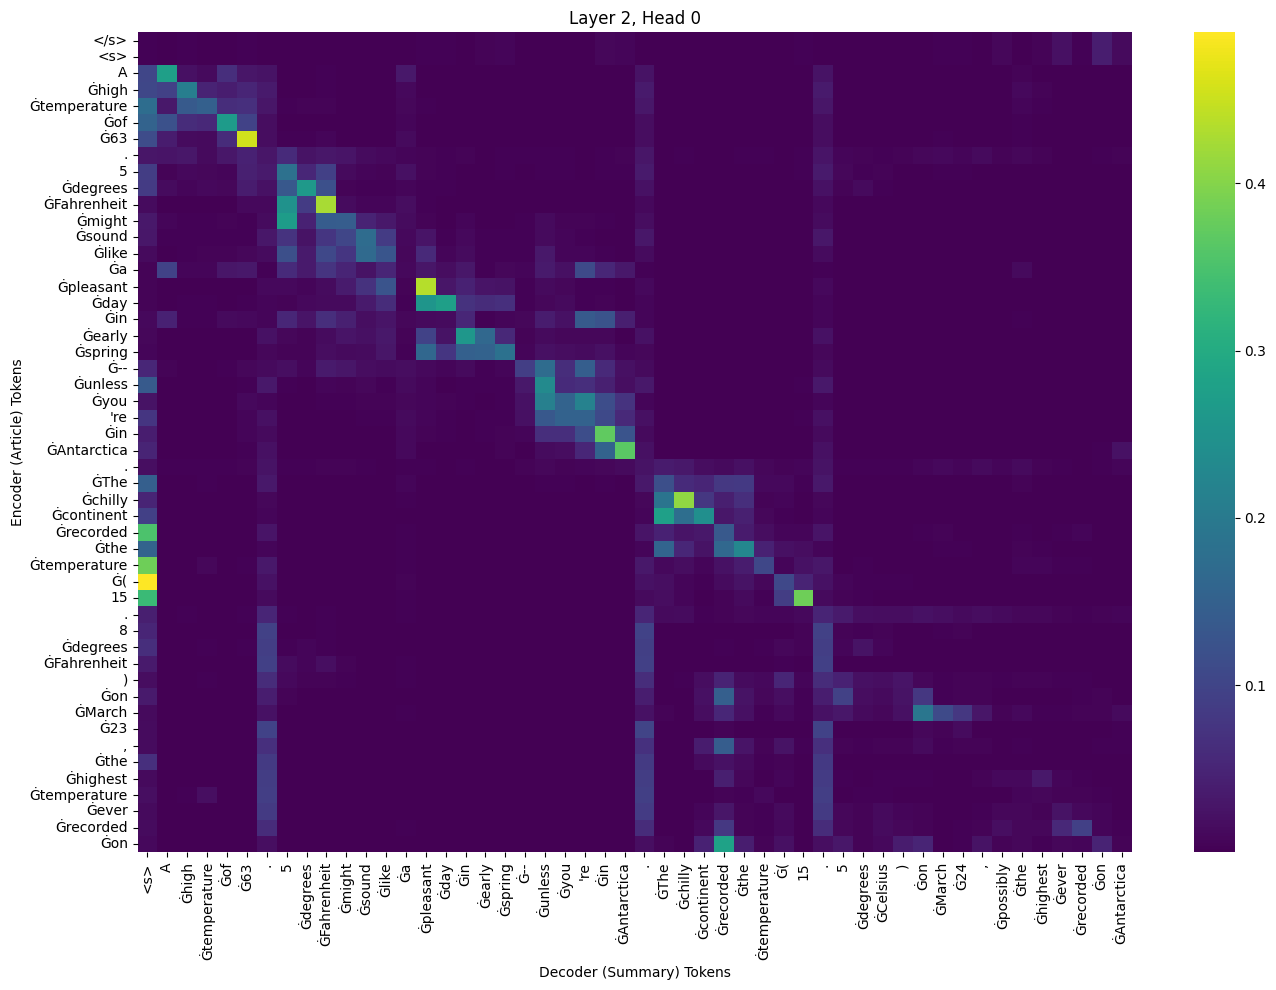

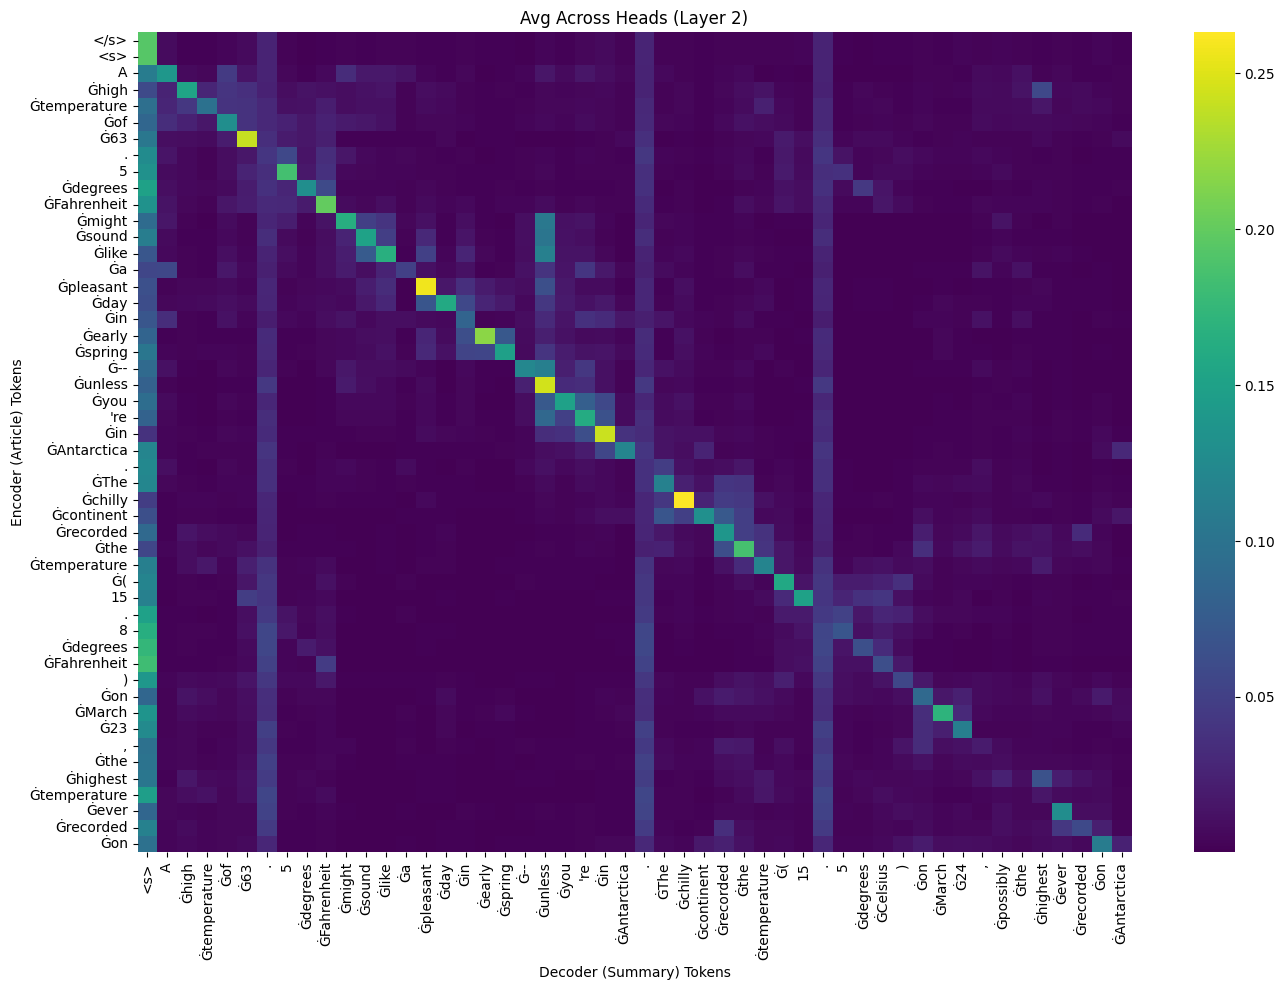

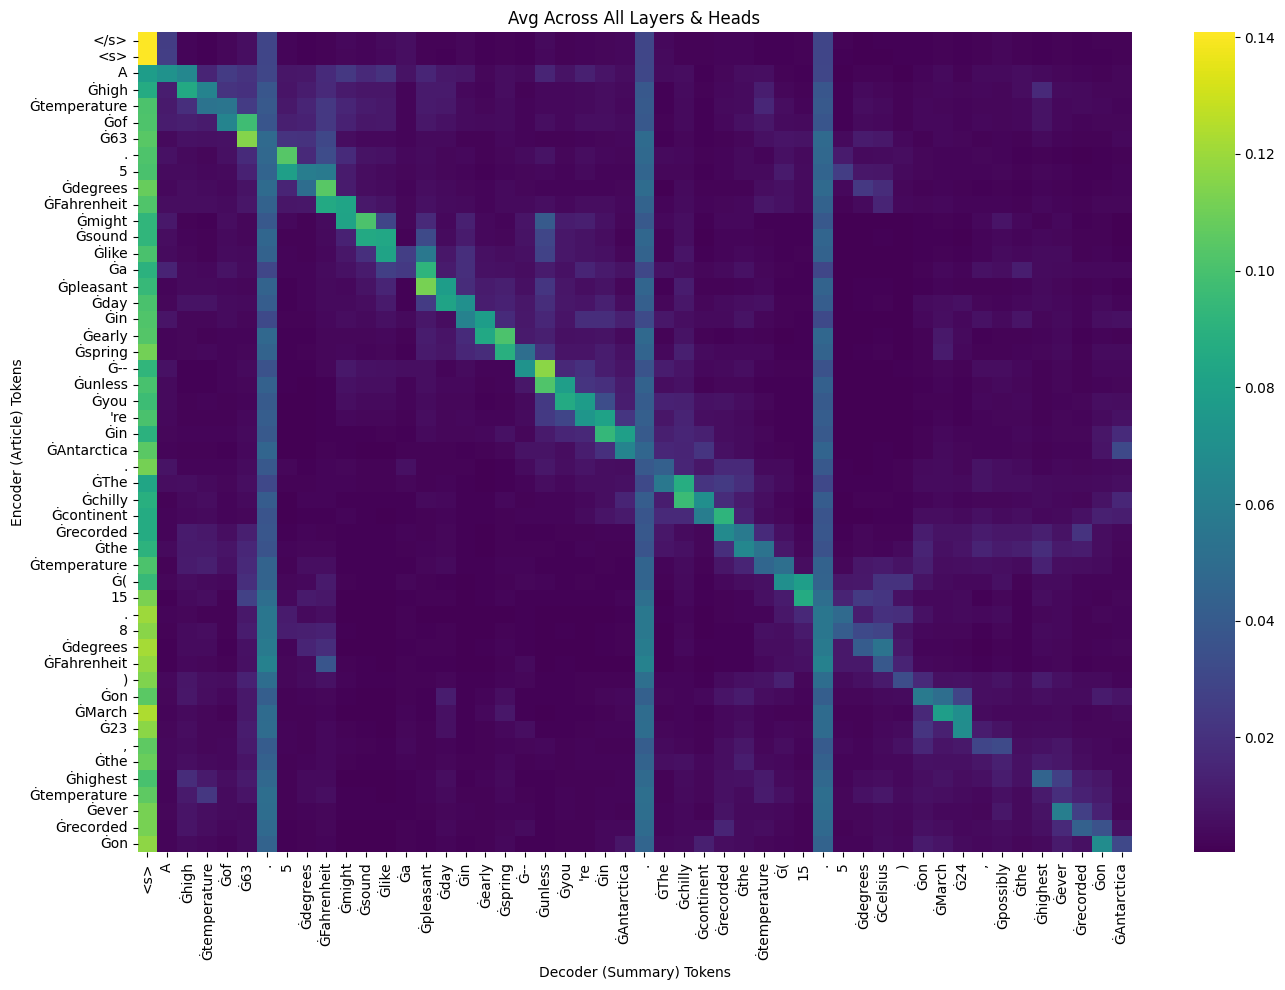

In [273]:
# For BART (layer 2, head 0)
article = "A high temperature of 63.5 degrees Fahrenheit might sound like a pleasant day in early spring -- unless you're in Antarctica. The chilly continent recorded the temperature (15.5 degrees Celsius) on March 24, possibly the highest ever recorded on Antarctica, according to the Weather Underground. The temperature was recorded at Argentina's Esperanza Base on the northern tip of the Antarctica Peninsula, according to CNN affiliate WTNH. (Note to map lovers: The Argentine base is not geographically part of the South American continent.) The World Meteorological Organization, a specialized United Nations agency, is in the process of setting up an international ad-hoc committee of about 10 blue-ribbon climatologists and meteorologists to begin collecting relevant evidence, said Randy Cerveny, the agency's lead rapporteur of weather and climate extremes and Arizona State University professor of geographical sciences. The committee will examine the equipment used to measure the temperature, whether it was in good working order, whether the correct monitoring procedures were followed, whether the equipment was placed in the correct location and whether the measurement is matched by corresponding records from surrounding stations, Cerveny said. The committee will discuss the issues and make a recommendation to Cerveny, who will make an official finding, probably by late summer or early fall. Researchers who study climate change carefully watch weather changes in the Antarctic region and elsewhere for evidence that the Earth is getting warmer."
cross_att, enc_toks, dec_toks = get_attention_full(bart_model_normal, bart_tokenizer_normal, article)

plot_attention_single_head(cross_att, enc_toks, dec_toks, layer=2, head=0)
plot_attention_avg_heads(cross_att, enc_toks, dec_toks, layer=2)
plot_attention_avg_all(cross_att, enc_toks, dec_toks)

In [266]:
cross_attentions, inputs, summary_ids = get_attention(pegasus_model, pegasus_tokenizer, article)
print(type(summary_ids))
print(summary_ids.size())

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.
  default_config_dict = GenerationConfig().to_dict()


<class 'torch.Tensor'>
torch.Size([1, 47])


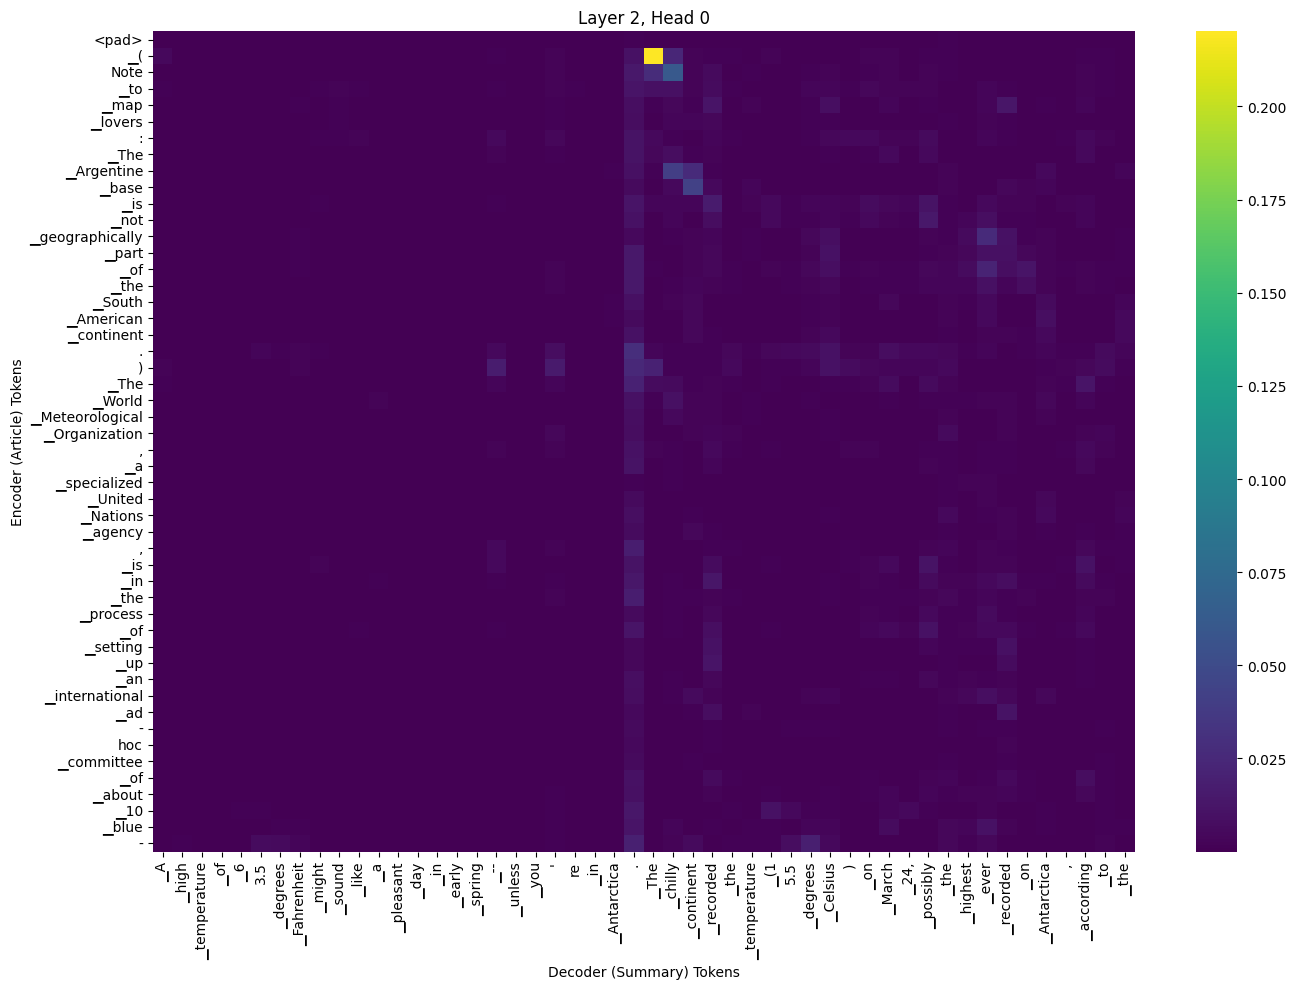

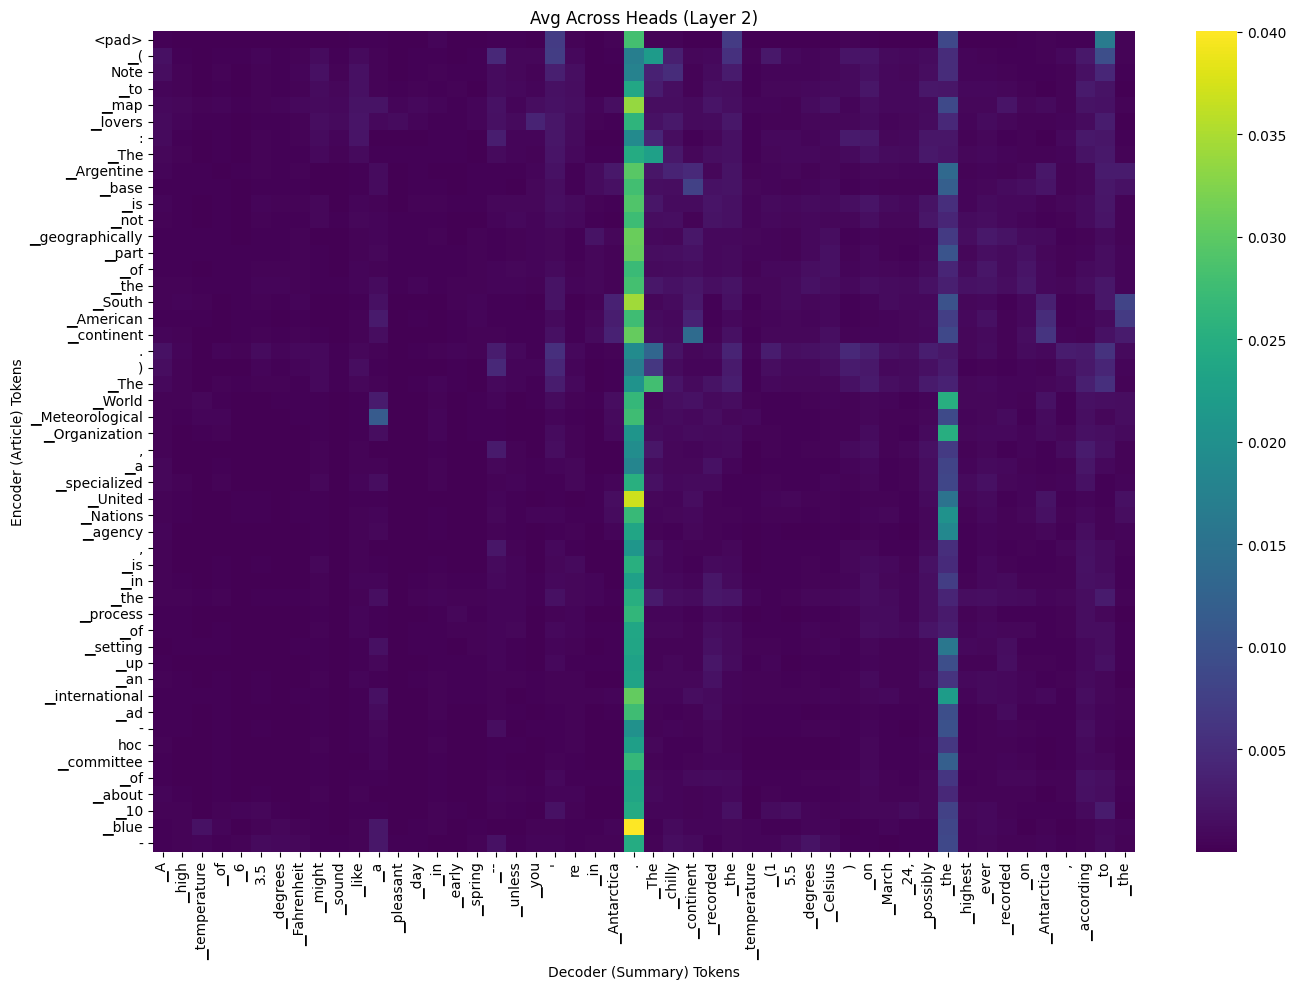

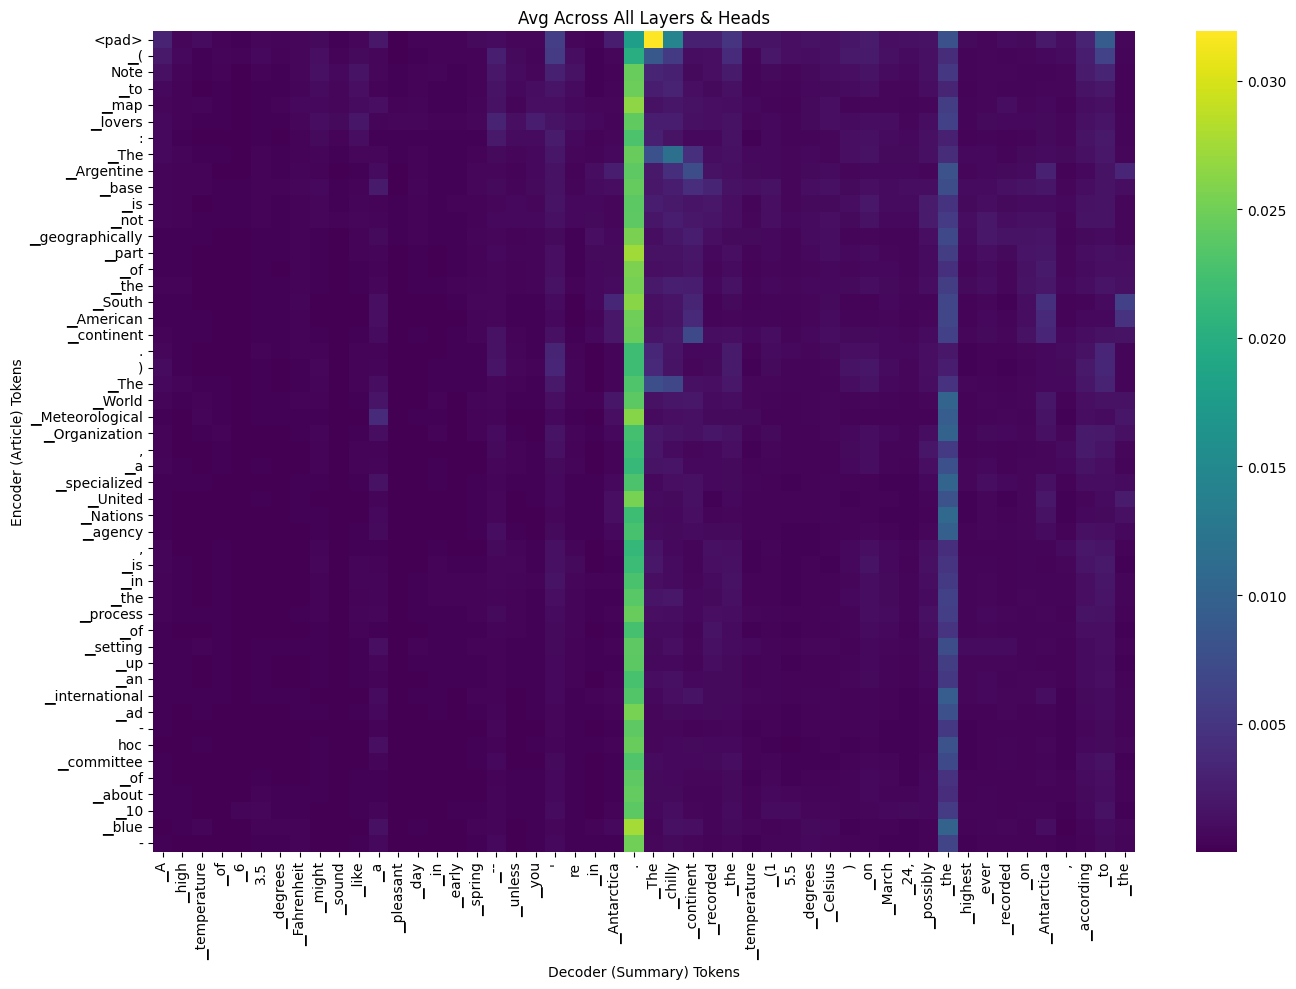

In [274]:
# For Pegasus
article = "A high temperature of 63.5 degrees Fahrenheit might sound like a pleasant day in early spring -- unless you're in Antarctica. The chilly continent recorded the temperature (15.5 degrees Celsius) on March 24, possibly the highest ever recorded on Antarctica, according to the Weather Underground. The temperature was recorded at Argentina's Esperanza Base on the northern tip of the Antarctica Peninsula, according to CNN affiliate WTNH. (Note to map lovers: The Argentine base is not geographically part of the South American continent.) The World Meteorological Organization, a specialized United Nations agency, is in the process of setting up an international ad-hoc committee of about 10 blue-ribbon climatologists and meteorologists to begin collecting relevant evidence, said Randy Cerveny, the agency's lead rapporteur of weather and climate extremes and Arizona State University professor of geographical sciences. The committee will examine the equipment used to measure the temperature, whether it was in good working order, whether the correct monitoring procedures were followed, whether the equipment was placed in the correct location and whether the measurement is matched by corresponding records from surrounding stations, Cerveny said. The committee will discuss the issues and make a recommendation to Cerveny, who will make an official finding, probably by late summer or early fall. Researchers who study climate change carefully watch weather changes in the Antarctic region and elsewhere for evidence that the Earth is getting warmer."
cross_attentions, inputs, summary_ids = get_attention_full(pegasus_model_normal, pegasus_tokenizer_normal, article)

plot_attention_single_head(cross_attentions, inputs, summary_ids, layer=2, head=0)
plot_attention_avg_heads(cross_attentions, inputs, summary_ids, layer=2)
plot_attention_avg_all(cross_attentions, inputs, summary_ids)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.
  default_config_dict = GenerationConfig().to_dict()


BART Summary: The temperature was recorded at Argentina's Esperanza Base on the northern tip of the Antarctica Peninsula. The World Meteorological Organization is in the process of setting up an international ad-hoc committee. Researchers watch weather changes in the Antarctic region and elsewhere for evidence that the Earth is getting warmer
Pegasus Summary: The temperature was recorded at Argentina's Esperanza Base on the Antarctica Peninsula .<n>The World Meteorological Organization is setting up an ad-hoc committee .<n>The committee will examine the equipment used to measure the temperature .


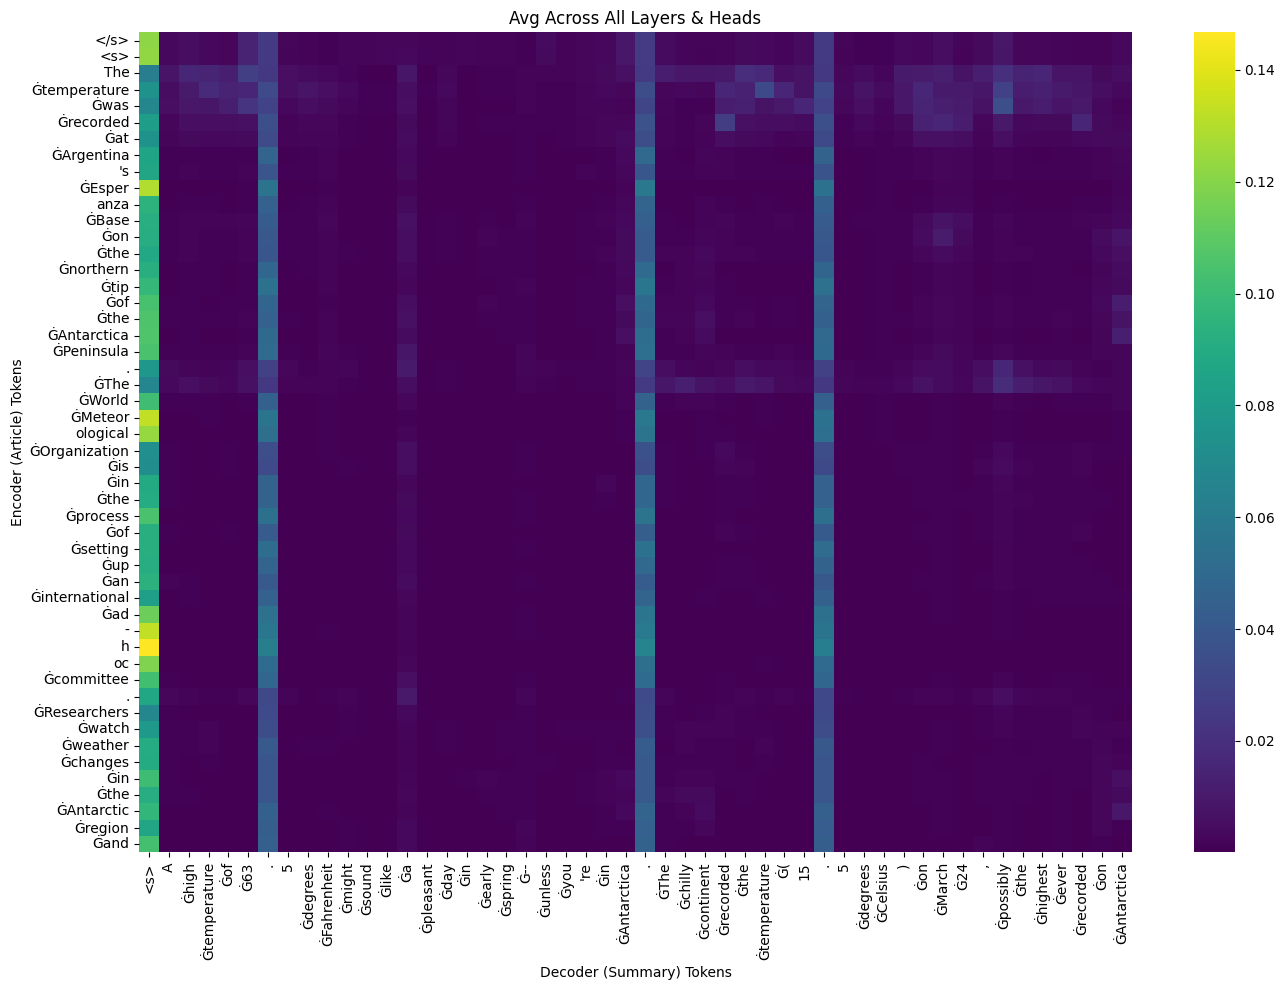

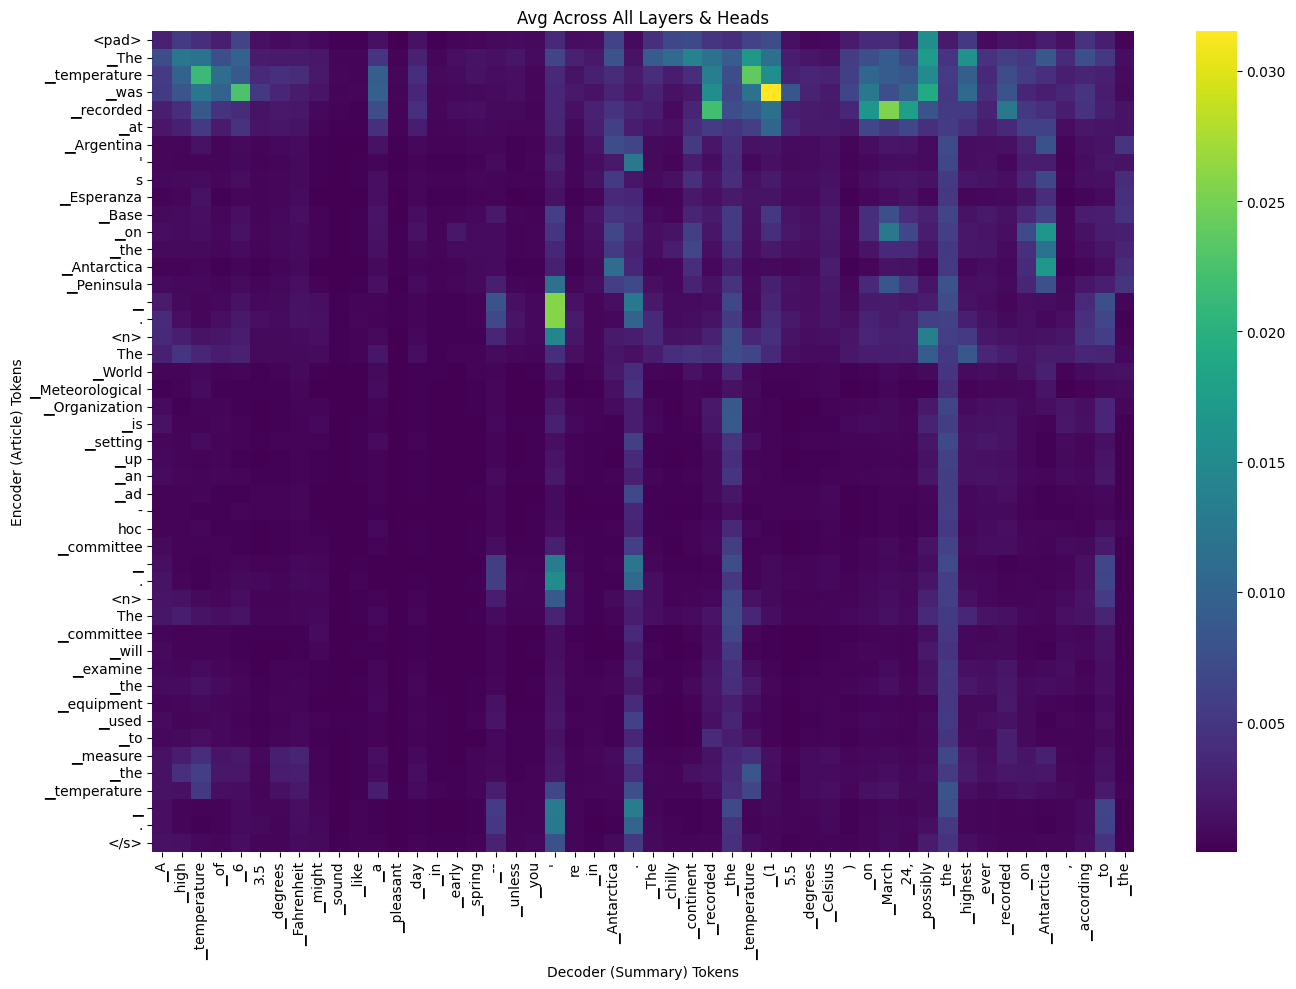

In [275]:
bart_att, bart_enc, bart_dec, bart_summary = get_model_attention(bart_model, bart_tokenizer, article)
peg_att, peg_enc, peg_dec, peg_summary = get_model_attention(pegasus_model, pegasus_tokenizer, article)

print("BART Summary:", bart_summary)
print("Pegasus Summary:", peg_summary)

# Now plot each
plot_attention_avg_all(bart_att, bart_enc, bart_dec)
plot_attention_avg_all(peg_att, peg_enc, peg_dec)

### Side By Side Comparison of Pegasus and Bart
Showing which tokens get the highest attention weights for the same article. (For my own curiosity)

In [16]:
def get_top_attention_tokens(attn_matrix, encoder_tokens, decoder_tokens, top_n=3):
    """
    For each decoder token, find the top-N attended encoder tokens.
    Returns a list of tuples: (decoder_token, [top_encoder_tokens])
    """
    attention_summary = []
    for i, dec_token in enumerate(decoder_tokens):
        if i >= attn_matrix.shape[0]:
            break
        attn_row = attn_matrix[i]  # shape: (encoder_len,)
        top_indices = attn_row.argsort()[-top_n:][::-1]
        top_tokens = [encoder_tokens[j] for j in top_indices]
        attention_summary.append((dec_token, top_tokens))
    return attention_summary

def compare_attention_focus(bart_att, bart_enc, bart_dec, peg_att, peg_enc, peg_dec, layer=2, head=0, top_n=3):
    print(f"\n Top {top_n} attended input tokens per summary token (Layer {layer}, Head {head}):\n")
    print(f"{'Summary Token':<20} | {'BART Focus':<40} | {'Pegasus Focus'}")
    print("-" * 90)

    bart_att_matrix = bart_att[layer][0, head].detach().numpy()
    peg_att_matrix = peg_att[layer][0, head].detach().numpy()

    bart_focus = get_top_attention_tokens(bart_att_matrix, bart_enc, bart_dec, top_n)
    peg_focus = get_top_attention_tokens(peg_att_matrix, peg_enc, peg_dec, top_n)

    for (dec_tok_b, bart_top), (dec_tok_p, peg_top) in zip(bart_focus, peg_focus):
        # (They might differ due to generation, so align loosely)
        print(f"{dec_tok_b:<20} | {', '.join(bart_top):<40} | {', '.join(peg_top)}")

In [280]:
bart_att, bart_enc, bart_dec, bart_summary = get_model_attention(bart_model, bart_tokenizer, article)
peg_att, peg_enc, peg_dec, peg_summary = get_model_attention(pegasus_model, pegasus_tokenizer, article)
print("BART Summary:   ", bart_summary)
print("Pegasus Summary:", peg_summary)

BART Summary:    The temperature was recorded at Argentina's Esperanza Base on the northern tip of the Antarctica Peninsula. The World Meteorological Organization is in the process of setting up an international ad-hoc committee. Researchers watch weather changes in the Antarctic region and elsewhere for evidence that the Earth is getting warmer
Pegasus Summary: The temperature was recorded at Argentina's Esperanza Base on the Antarctica Peninsula .<n>The World Meteorological Organization is setting up an ad-hoc committee .<n>The committee will examine the equipment used to measure the temperature .


In [278]:
compare_attention_focus(
    bart_att, bart_enc, bart_dec,
    peg_att, peg_enc, peg_dec,
    layer=2, head=0, top_n=3
)


🔍 Top 3 attended input tokens per summary token (Layer 2, Head 0):

Summary Token        | BART Focus                               | Pegasus Focus
------------------------------------------------------------------------------------------
</s>                 | Ġgeographically, Ġtip, Ġon               | ,, ,, ,
<s>                  | Ġgeographically, Ġtip, Ġon               | ,, ▁possibly, ,
The                  | <s>, ., .                                | ▁temperature, ▁temperature, ▁high
Ġtemperature         | <s>, ., .                                | ▁possibly, ▁(1, ,
Ġwas                 | ĠThe, Ġwas, Ġtemperature                 | ▁temperature, ▁recorded, ▁recorded
Ġrecorded            | Ġrecorded, Ġwas, ĠThe                    | ▁on, ▁at, ▁on
Ġat                  | Ġat, Ġwas, ĠThe                          | ▁Argentina, ▁Esperanza, ▁Argentine
ĠArgentina           | ĠArgentina, Ġat, Ġwas                    | ,, ,, ,
's                   | Ġwas, Ġat, ĠThe                          